In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
import os, os.path
from scipy import interpolate, signal
import pickle
import galpy.df
from galpy.orbit import Orbit
from galpy.potential import LogarithmicHaloPotential
from galpy.actionAngle import actionAngleIsochroneApprox, estimateBIsochrone
from galpy.df import streamdf
from galpy.util import bovy_plot, bovy_coords, bovy_conversion #for unit conversions
from galpy.util import save_pickles
import streampepperdf
import simulate_streampepper
from gd1_util import R0, V0
import custom_stripping_df
from matplotlib.ticker import NullFormatter
nullfmt= NullFormatter()
import matplotlib.lines as mlines
from matplotlib import gridspec
import seaborn as sns
%pylab inline
sns.set_style('ticks',
              {'xtick.direction': u'in',
               'ytick.direction': u'in',
               'axes.labelsize': 18.0,
               'axes.titlesize': 18.0,
               'figure.figsize': array([ 6.64,  4.  ]),
               'grid.linewidth': 2.0,
               'legend.fontsize': 18.0,
               'lines.linewidth': 2.0,
               'lines.markeredgewidth': 0.0,
               'lines.markersize': 14.0,
               'patch.linewidth': 0.6,
               'xtick.labelsize': 16.0,
               'xtick.major.pad': 14.0,
               'xtick.major.width': 2.0,
               'xtick.minor.width': 1.0,
               'ytick.labelsize': 16.0,
               'ytick.major.pad': 14.0,
               'ytick.major.width': 2.0,})
save_figures= False

/Users/bovy/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))

Populating the interactive namespace from numpy and matplotlib


# Comparison to $N$-body simulations

In [3]:
lp= LogarithmicHaloPotential(normalize=1.,q=0.9)
aAI= actionAngleIsochroneApprox(pot=lp,b=0.8)
# Convenience function
def convert_to_cylindrical(xv):
    R,phi,Z= bovy_coords.rect_to_cyl(xv[:,0],xv[:,1],xv[:,2])
    vR,vT,vZ= bovy_coords.rect_to_cyl_vec(xv[:,3],xv[:,4],xv[:,5],R,phi,Z,cyl=True)
    out= numpy.empty_like(xv)
    # Preferred galpy arrangement of cylindrical coordinates
    out[:,0]= R
    out[:,1]= vR
    out[:,2]= vT
    out[:,3]= Z
    out[:,4]= vZ
    out[:,5]= phi
    return out
# Progenitor
xv_prog_init= numpy.array([30.,0.,0.,0., 105.74895, 105.74895])
RvR_prog_init= convert_to_cylindrical(xv_prog_init[:,numpy.newaxis].T)[0,:]
prog_init= Orbit([RvR_prog_init[0]/R0,RvR_prog_init[1]/V0,RvR_prog_init[2]/V0,
                  RvR_prog_init[3]/R0,RvR_prog_init[4]/V0,RvR_prog_init[5]],ro=R0,vo=V0)
times= numpy.linspace(0.,10.88/bovy_conversion.time_in_Gyr(V0,R0),1001)
prog_init.integrate(times,lp)
xv_unp_peri_prog= [prog_init.x(times[-1]),prog_init.y(times[-1]),prog_init.z(times[-1]),
              prog_init.vx(times[-1]),prog_init.vy(times[-1]),prog_init.vz(times[-1])]
RvR_unp_peri_prog= convert_to_cylindrical(numpy.array(xv_unp_peri_prog)[:,numpy.newaxis].T)[0,:]
prog_unp_peri= Orbit([RvR_unp_peri_prog[0]/R0,RvR_unp_peri_prog[1]/V0,RvR_unp_peri_prog[2]/V0,
                      RvR_unp_peri_prog[3]/R0+0.0,RvR_unp_peri_prog[4]/V0,RvR_unp_peri_prog[5]])

In [4]:
def plot_single_comparison(xv_unp_peri,xv_1e6_peri,
                           xv_mock_unp,xv_mock_per,xv_mock_per_onlyopar,
                           log10mass,alpha=0.1):
    scale= 10.**(0.6*(log10mass-6.))
    gs=  gridspec.GridSpec(2,3,height_ratios=[1.,1.],hspace=0.2,wspace=0.35)
    gs2= gridspec.GridSpec(2,3,height_ratios=[1.,1.],hspace=0.2,wspace=0.35)
    subplot(gs2[0])
    bovy_plot.bovy_plot(sdf_smooth._ObsTrackXY[:,0]*R0,
                        sdf_smooth._ObsTrackXY[:,0]*R0*0.,
                        '-',color=sns.color_palette()[3],
                        ylabel=r'$\delta x/\mathrm{kpc}$',gcf=True,yrange=[-.15*scale,.15*scale],
                       xrange=[-5.,15.])
    plot(xv_unp_peri[(xv_unp_peri[:,1] < 5.),0],xv_1e6_peri[(xv_unp_peri[:,1] < 5.),0]
         -xv_unp_peri[(xv_unp_peri[:,1] < 5.),0],
         'k.',ms=1,alpha=alpha,rasterized=True)
    plot(xv_mock_unp[:,0]*R0,(xv_mock_per[:,0]-xv_mock_unp[:,0])*R0,'.',color=sns.color_palette()[2],
         ms=1.5,alpha=alpha,rasterized=True)
    plot(xv_mock_unp[:,0]*R0,(xv_mock_per_onlyopar[:,0]-xv_mock_unp[:,0])*R0,'.',
         color=sns.color_palette()[4],ms=1.5,alpha=alpha,rasterized=True)
    bovy_plot.bovy_text(r'$M = 10^%i\,M_\odot$' % log10mass,size=18.,top_left=True)
    subplot(gs2[1])
    bovy_plot.bovy_plot(sdf_smooth._ObsTrackXY[:,0]*R0,
                        sdf_smooth._ObsTrackXY[:,0]*R0*0.,
                        '-',color=sns.color_palette()[3],
                        ylabel=r'$\delta y/\mathrm{kpc}$',gcf=True,yrange=[-.05*scale,.05*scale],
                       xrange=[-5.,15.])
    plot(xv_unp_peri[(xv_unp_peri[:,1] < 5.),0],xv_1e6_peri[(xv_unp_peri[:,1] < 5.),1]
         -xv_unp_peri[(xv_unp_peri[:,1] < 5.),1],
         'k.',ms=1,alpha=alpha,rasterized=True)
    plot(xv_mock_unp[:,0]*R0,(xv_mock_per[:,1]-xv_mock_unp[:,1])*R0,'.',color=sns.color_palette()[2],
         ms=1.5,alpha=alpha,rasterized=True)
    plot(xv_mock_unp[:,0]*R0,(xv_mock_per_onlyopar[:,1]-xv_mock_unp[:,1])*R0,'.',
         color=sns.color_palette()[4],ms=1.5,alpha=alpha,rasterized=True)
    l1= pyplot.legend((mlines.Line2D([], [], color='k',marker='o',ls='none'),
                       mlines.Line2D([], [], color=sns.color_palette()[2],marker='o',ls='none')),
                      (r'$\mathrm{Simulation}$',
                       r'$\mathrm{Model}$'),
                       loc='upper left',#bbox_to_anchor=(.02,.02),
                       numpoints=1,
                       prop={'size':20},
                       frameon=False)
    l2= pyplot.legend((mlines.Line2D([], [], color=sns.color_palette()[4],marker='o',ls='none'),),
                      (r'$\mathrm{Parallel\!\!-\!\!only\ model}$',),
                       loc='lower left',#bbox_to_anchor=(.02,.02),
                       numpoints=1,
                       prop={'size':20},
                       frameon=False)
    pyplot.gca().add_artist(l1)
    subplot(gs2[2])
    bovy_plot.bovy_plot(sdf_smooth._ObsTrackXY[:,0]*R0,
                        sdf_smooth._ObsTrackXY[:,0]*R0*0.,
                        '-',color=sns.color_palette()[3],
                        ylabel=r'$\delta z/\mathrm{kpc}$',gcf=True,yrange=[-.15*scale,.15*scale],
                       xrange=[-5.,15.])
    plot(xv_unp_peri[(xv_unp_peri[:,1] < 5.),0],xv_1e6_peri[(xv_unp_peri[:,1] < 5.),2]-xv_unp_peri[(xv_unp_peri[:,1] < 5.),2],
         'k.',ms=1,alpha=alpha,rasterized=True)
    plot(xv_mock_unp[:,0]*R0,(xv_mock_per[:,2]-xv_mock_unp[:,2])*R0,'.',color=sns.color_palette()[2],
         ms=1.5,alpha=alpha,rasterized=True)
    plot(xv_mock_unp[:,0]*R0,(xv_mock_per_onlyopar[:,2]-xv_mock_unp[:,2])*R0,'.',
         color=sns.color_palette()[4],ms=1.5,alpha=alpha,rasterized=True)
    subplot(gs2[3])
    bovy_plot.bovy_plot(sdf_smooth._ObsTrackXY[:,0]*R0,
                        sdf_smooth._ObsTrackXY[:,0]*R0*0.,
                        '-',xlabel=r'$x/\mathrm{kpc}$',color=sns.color_palette()[3],
                        ylabel=r'$\delta v_x/(\mathrm{km\,s}^{-1})$',gcf=True,yrange=[-.75*scale,.75*scale],
                       xrange=[-5.,15.])
    plot(xv_unp_peri[(xv_unp_peri[:,1] < 5.),0],xv_1e6_peri[(xv_unp_peri[:,1] < 5.),3]-xv_unp_peri[(xv_unp_peri[:,1] < 5.),3],
         'k.',ms=1,alpha=alpha,rasterized=True)
    plot(xv_mock_unp[:,0]*R0,(xv_mock_per[:,3]-xv_mock_unp[:,3])*V0,'.',color=sns.color_palette()[2],
         ms=1.5,alpha=alpha,rasterized=True)
    plot(xv_mock_unp[:,0]*R0,(xv_mock_per_onlyopar[:,3]-xv_mock_unp[:,3])*V0,'.',
         color=sns.color_palette()[4],ms=1.5,alpha=alpha,rasterized=True)
    subplot(gs2[4])
    bovy_plot.bovy_plot(sdf_smooth._ObsTrackXY[:,0]*R0,
                        sdf_smooth._ObsTrackXY[:,0]*R0*0.,
                        '-',xlabel=r'$x/\mathrm{kpc}$',color=sns.color_palette()[3],
                        ylabel=r'$\delta v_y/(\mathrm{km\,s}^{-1})$',gcf=True,yrange=[-2.*scale,2.*scale],
                       xrange=[-5.,15.])
    plot(xv_unp_peri[(xv_unp_peri[:,1] < 5.),0],xv_1e6_peri[(xv_unp_peri[:,1] < 5.),4]-xv_unp_peri[(xv_unp_peri[:,1] < 5.),4],
         'k.',ms=1,alpha=alpha,rasterized=True)
    plot(xv_mock_unp[:,0]*R0,(xv_mock_per[:,4]-xv_mock_unp[:,4])*V0,'.',color=sns.color_palette()[2],
         ms=1.5,alpha=alpha,rasterized=True)
    plot(xv_mock_unp[:,0]*R0,(xv_mock_per_onlyopar[:,4]-xv_mock_unp[:,4])*V0,'.',
         color=sns.color_palette()[4],ms=1.5,alpha=alpha,rasterized=True)
    subplot(gs2[5])
    bovy_plot.bovy_plot(sdf_smooth._ObsTrackXY[:,0]*R0,
                        sdf_smooth._ObsTrackXY[:,0]*R0*0.,
                        '-',xlabel=r'$x/\mathrm{kpc}$',color=sns.color_palette()[3],
                        ylabel=r'$\delta v_z/(\mathrm{km\,s}^{-1})$',gcf=True,yrange=[-.75*scale,.75*scale],
                       xrange=[-5.,15.])
    plot(xv_unp_peri[(xv_unp_peri[:,1] < 5.),0],xv_1e6_peri[(xv_unp_peri[:,1] < 5.),5]-xv_unp_peri[(xv_unp_peri[:,1] < 5.),5],
         'k.',ms=1,alpha=alpha,rasterized=True)
    plot(xv_mock_unp[:,0]*R0,(xv_mock_per[:,5]-xv_mock_unp[:,5])*V0,'.',color=sns.color_palette()[2],
         ms=1.5,alpha=alpha,rasterized=True)
    plot(xv_mock_unp[:,0]*R0,(xv_mock_per_onlyopar[:,5]-xv_mock_unp[:,5])*V0,'.',
         color=sns.color_palette()[4],ms=1.5,alpha=alpha,rasterized=True)

## $10^8\,M_\odot$

In [5]:
xvid= numpy.loadtxt(os.path.join(os.getenv('DATADIR'),'streamgap-aa','nonzeroJz','snapshot_2nd_peri_unperturbed.txt'))
xv_unp_peri= xvid[:,:6]
xv_unp_peri= xv_unp_peri[numpy.argsort(xvid[:,6])]
RvR_unp_peri= convert_to_cylindrical(xv_unp_peri)
xvid= numpy.loadtxt(os.path.join(os.getenv('DATADIR'),'streamgap-aa','nonzeroJz','snapshot_2nd_peri_1e8.txt'))
xv_1e8_peri= xvid[:,:6]
xv_1e8_peri= xv_1e8_peri[numpy.argsort(xvid[:,6])]
RvR_1e8_peri= convert_to_cylindrical(xv_1e8_peri)

In [6]:
sigv= 0.365*(10./2.)**(1./3.) # km/s, based on M^(1/3) scaling applied to 10^5 vs. 2x10^4 in my paper
sdf_smooth= \
    custom_stripping_df.streamdf_jason(sigv/V0,progenitor=prog_unp_peri,pot=lp,aA=aAI,
                                       leading=False,nTrackChunks=101,nTrackIterations=1,
                                       sigMeanOffset=4.5,
                                       tdisrupt=10.88/bovy_conversion.time_in_Gyr(V0,R0),
                                       Vnorm=V0,Rnorm=R0)
sdf_1e8= \
    custom_stripping_df.streamgapdf_jason(sigv/V0,progenitor=prog_unp_peri,pot=lp,aA=aAI,
                                          leading=False,nTrackChunks=101,nTrackIterations=1,
                                          nTrackChunksImpact=116,
                                          sigMeanOffset=4.5,
                                          tdisrupt=10.88/bovy_conversion.time_in_Gyr(V0,R0),
                                          Vnorm=V0,Rnorm=R0,
                                          impactb=0.,
                                          subhalovel=numpy.array([6.82200571,132.7700529,149.4174464])/V0,
                                          timpact=0.88/bovy_conversion.time_in_Gyr(V0,R0),
                                          impact_angle=-2.34,
                                          GM=10.**-2./bovy_conversion.mass_in_1010msol(V0,R0),
                                          rs=0.625/R0)
sdf_1e8_onlyopar= \
    custom_stripping_df.streamgapdf_jason_onlyopar(sigv/V0,progenitor=prog_unp_peri,pot=lp,aA=aAI,
                                          leading=False,nTrackChunks=101,nTrackIterations=1,
                                          nTrackChunksImpact=116,
                                          sigMeanOffset=4.5,
                                          tdisrupt=10.88/bovy_conversion.time_in_Gyr(V0,R0),
                                          Vnorm=V0,Rnorm=R0,
                                          impactb=0.,
                                          subhalovel=numpy.array([6.82200571,132.7700529,149.4174464])/V0,
                                          timpact=0.88/bovy_conversion.time_in_Gyr(V0,R0),
                                          impact_angle=-2.34,
                                          GM=10.**-2./bovy_conversion.mass_in_1010msol(V0,R0),
                                          rs=0.625/R0)

In [7]:
numpy.random.seed(1)
xv_mock_unp= sdf_smooth.sample(n=100000,xy=True).T
numpy.random.seed(1) # Same seed, such that the mocks are the same, except for the kick
xv_mock_per= sdf_1e8.sample(n=100000,xy=True).T
numpy.random.seed(1) # Same seed, such that the mocks are the same, except for the kick
xv_mock_per_onlyopar= sdf_1e8_onlyopar.sample(n=100000,xy=True).T

/Users/bovy/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))



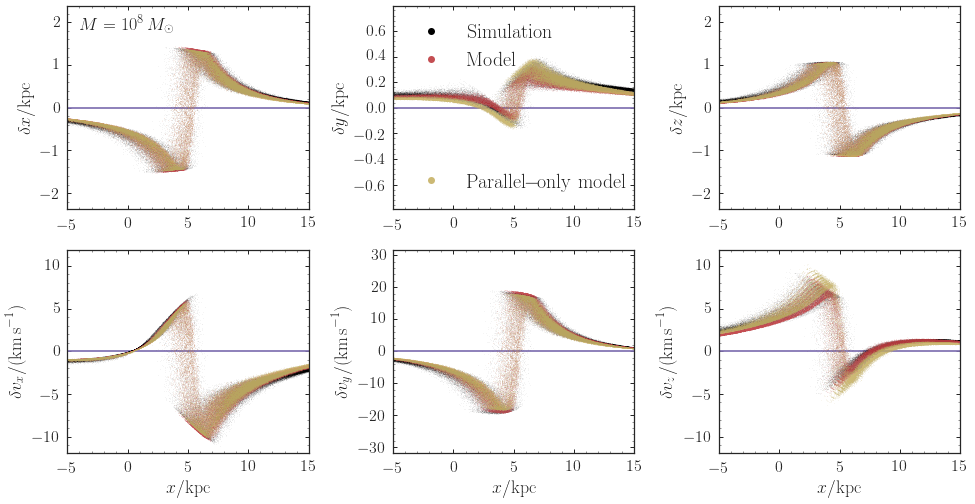

In [8]:
bovy_plot.bovy_print(axes_labelsize=18.,text_fontsize=12.,xtick_labelsize=16.,ytick_labelsize=16.)
figsize(16,8)
plot_single_comparison(xv_unp_peri,xv_1e8_peri,xv_mock_unp,xv_mock_per,xv_mock_per_onlyopar,8.)

## $10^7\,M_\odot$

In [9]:
xvid= numpy.loadtxt(os.path.join(os.getenv('DATADIR'),'streamgap-aa','nonzeroJz','snapshot_2nd_peri_unperturbed.txt'))
xv_unp_peri= xvid[:,:6]
xv_unp_peri= xv_unp_peri[numpy.argsort(xvid[:,6])]
RvR_unp_peri= convert_to_cylindrical(xv_unp_peri)
xvid= numpy.loadtxt(os.path.join(os.getenv('DATADIR'),'streamgap-aa','nonzeroJz','snapshot_2nd_peri_1e7.txt'))
xv_1e7_peri= xvid[:,:6]
xv_1e7_peri= xv_1e7_peri[numpy.argsort(xvid[:,6])]
RvR_1e7_peri= convert_to_cylindrical(xv_1e7_peri)

In [10]:
sigv= 0.365*(10./2.)**(1./3.) # km/s, based on M^(1/3) scaling applied to 10^5 vs. 2x10^4 in my paper
sdf_smooth= \
    custom_stripping_df.streamdf_jason(sigv/V0,progenitor=prog_unp_peri,pot=lp,aA=aAI,
                                       leading=False,nTrackChunks=101,nTrackIterations=1,
                                       sigMeanOffset=4.5,
                                       tdisrupt=10.88/bovy_conversion.time_in_Gyr(V0,R0),
                                       Vnorm=V0,Rnorm=R0)
sdf_1e7= \
    custom_stripping_df.streamgapdf_jason(sigv/V0,progenitor=prog_unp_peri,pot=lp,aA=aAI,
                                          leading=False,nTrackChunks=101,nTrackIterations=1,
                                          nTrackChunksImpact=116,
                                          sigMeanOffset=4.5,
                                          tdisrupt=10.88/bovy_conversion.time_in_Gyr(V0,R0),
                                          Vnorm=V0,Rnorm=R0,
                                          impactb=0.,
                                          subhalovel=numpy.array([6.82200571,132.7700529,149.4174464])/V0,
                                          timpact=0.88/bovy_conversion.time_in_Gyr(V0,R0),
                                          impact_angle=-2.34,
                                          GM=10.**-3./bovy_conversion.mass_in_1010msol(V0,R0),
                                          rs=0.250/R0)
sdf_1e7_onlyopar= \
    custom_stripping_df.streamgapdf_jason_onlyopar(sigv/V0,progenitor=prog_unp_peri,pot=lp,aA=aAI,
                                          leading=False,nTrackChunks=101,nTrackIterations=1,
                                          nTrackChunksImpact=116,
                                          sigMeanOffset=4.5,
                                          tdisrupt=10.88/bovy_conversion.time_in_Gyr(V0,R0),
                                          Vnorm=V0,Rnorm=R0,
                                          impactb=0.,
                                          subhalovel=numpy.array([6.82200571,132.7700529,149.4174464])/V0,
                                          timpact=0.88/bovy_conversion.time_in_Gyr(V0,R0),
                                          impact_angle=-2.34,
                                          GM=10.**-3./bovy_conversion.mass_in_1010msol(V0,R0),
                                          rs=0.250/R0)

In [11]:
numpy.random.seed(1)
xv_mock_unp= sdf_smooth.sample(n=100000,xy=True).T
numpy.random.seed(1) # Same seed, such that the mocks are the same, except for the kick
xv_mock_per= sdf_1e7.sample(n=100000,xy=True).T
numpy.random.seed(1) # Same seed, such that the mocks are the same, except for the kick
xv_mock_per_onlyopar= sdf_1e7_onlyopar.sample(n=100000,xy=True).T

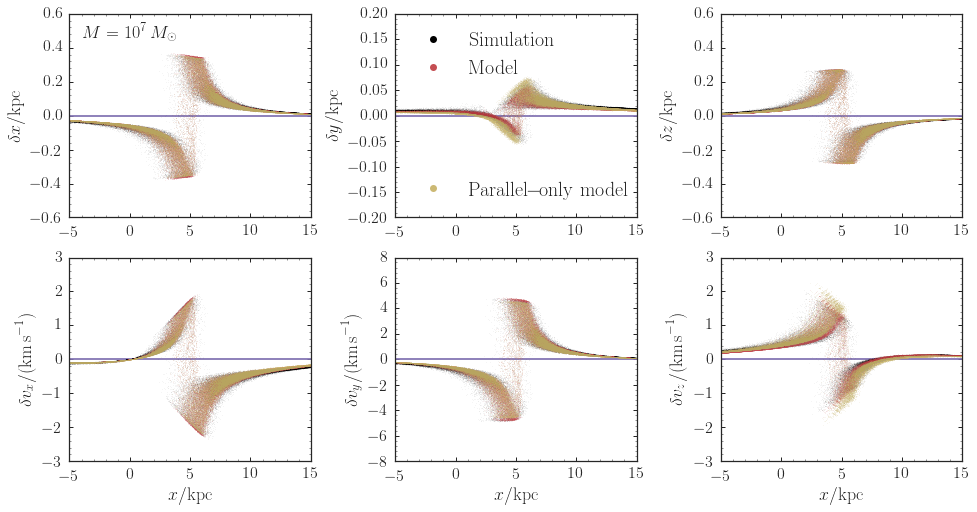

In [12]:
bovy_plot.bovy_print(axes_labelsize=18.,text_fontsize=12.,xtick_labelsize=16.,ytick_labelsize=16.)
figsize(16,8)
plot_single_comparison(xv_unp_peri,xv_1e7_peri,xv_mock_unp,xv_mock_per,xv_mock_per_onlyopar,7.)
if save_figures:
    plt.savefig(os.path.join(os.getenv('PAPERSDIR'),'2016-stream-stats','compare_nbody_single_1e7.pdf'),
                bbox_inches='tight')

## $10^6\,M_\odot$

In [13]:
xvid= numpy.loadtxt(os.path.join(os.getenv('DATADIR'),'streamgap-aa','nonzeroJz','snapshot_2nd_peri_unperturbed.txt'))
xv_unp_peri= xvid[:,:6]
xv_unp_peri= xv_unp_peri[numpy.argsort(xvid[:,6])]
RvR_unp_peri= convert_to_cylindrical(xv_unp_peri)
xvid= numpy.loadtxt(os.path.join(os.getenv('DATADIR'),'streamgap-aa','nonzeroJz','snapshot_880Myr_1e6Msun.txt'))
xv_1e6_peri= xvid[:,:6]
xv_1e6_peri= xv_1e6_peri[numpy.argsort(xvid[:,6])]
RvR_1e6_peri= convert_to_cylindrical(xv_1e6_peri)

In [14]:
sigv= 0.365*(10./2.)**(1./3.) # km/s, based on M^(1/3) scaling applied to 10^5 vs. 2x10^4 in my paper
sdf_smooth= \
    custom_stripping_df.streamdf_jason(sigv/V0,progenitor=prog_unp_peri,pot=lp,aA=aAI,
                                       leading=False,nTrackChunks=101,nTrackIterations=1,
                                       sigMeanOffset=4.5,
                                       tdisrupt=10.88/bovy_conversion.time_in_Gyr(V0,R0),
                                       Vnorm=V0,Rnorm=R0)
sdf_1e6= \
    custom_stripping_df.streamgapdf_jason(sigv/V0,progenitor=prog_unp_peri,pot=lp,aA=aAI,
                                          leading=False,nTrackChunks=101,nTrackIterations=1,
                                          nTrackChunksImpact=116,
                                          sigMeanOffset=4.5,
                                          tdisrupt=10.88/bovy_conversion.time_in_Gyr(V0,R0),
                                          Vnorm=V0,Rnorm=R0,
                                          impactb=0.,
                                          subhalovel=numpy.array([6.82200571,132.7700529,149.4174464])/V0,
                                          timpact=0.88/bovy_conversion.time_in_Gyr(V0,R0),
                                          impact_angle=-2.34,
                                          GM=10.**-4./bovy_conversion.mass_in_1010msol(V0,R0),
                                          rs=0.08/R0)
sdf_1e6_onlyopar= \
    custom_stripping_df.streamgapdf_jason_onlyopar(sigv/V0,progenitor=prog_unp_peri,pot=lp,aA=aAI,
                                          leading=False,nTrackChunks=101,nTrackIterations=1,
                                          nTrackChunksImpact=116,
                                          sigMeanOffset=4.5,
                                          tdisrupt=10.88/bovy_conversion.time_in_Gyr(V0,R0),
                                          Vnorm=V0,Rnorm=R0,
                                          impactb=0.,
                                          subhalovel=numpy.array([6.82200571,132.7700529,149.4174464])/V0,
                                          timpact=0.88/bovy_conversion.time_in_Gyr(V0,R0),
                                          impact_angle=-2.34,
                                          GM=10.**-4./bovy_conversion.mass_in_1010msol(V0,R0),
                                          rs=0.08/R0)

In [15]:
numpy.random.seed(1)
xv_mock_unp= sdf_smooth.sample(n=100000,xy=True).T
numpy.random.seed(1) # Same seed, such that the mocks are the same, except for the kick
xv_mock_per= sdf_1e6.sample(n=100000,xy=True).T
numpy.random.seed(1) # Same seed, such that the mocks are the same, except for the kick
xv_mock_per_onlyopar= sdf_1e6_onlyopar.sample(n=100000,xy=True).T

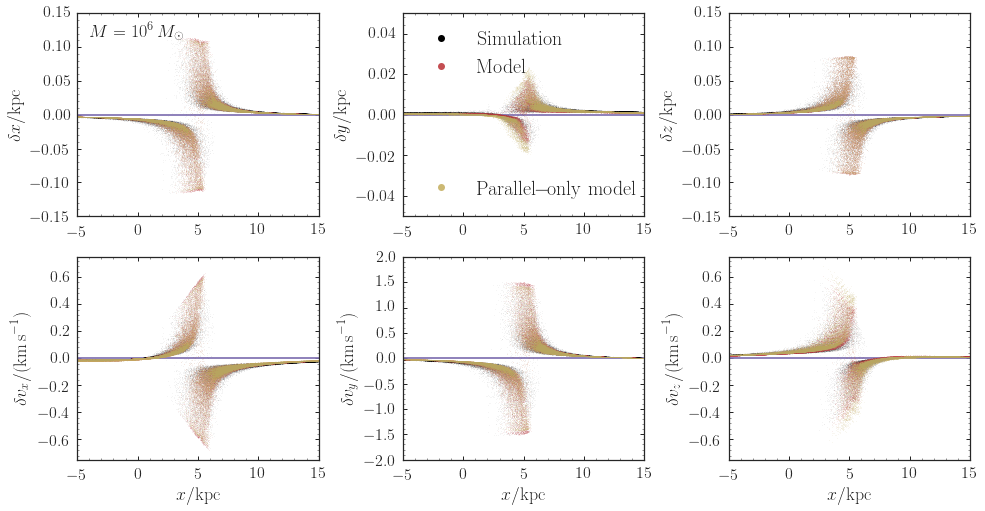

In [16]:
bovy_plot.bovy_print(axes_labelsize=18.,text_fontsize=12.,xtick_labelsize=16.,ytick_labelsize=16.)
figsize(16,8)
plot_single_comparison(xv_unp_peri,xv_1e6_peri,xv_mock_unp,xv_mock_per,xv_mock_per_onlyopar,6.)

## $10^5\,M_\odot$

In [17]:
xvid= numpy.loadtxt(os.path.join(os.getenv('DATADIR'),'streamgap-aa','nonzeroJz','snapshot_2nd_peri_unperturbed.txt'))
xv_unp_peri= xvid[:,:6]
xv_unp_peri= xv_unp_peri[numpy.argsort(xvid[:,6])]
RvR_unp_peri= convert_to_cylindrical(xv_unp_peri)
xvid= numpy.loadtxt(os.path.join(os.getenv('DATADIR'),'streamgap-aa','nonzeroJz','snapshot_880Myr_1e5Msun.txt'))
xv_1e5_peri= xvid[:,:6]
xv_1e5_peri= xv_1e5_peri[numpy.argsort(xvid[:,6])]
RvR_1e5_peri= convert_to_cylindrical(xv_1e5_peri)

In [18]:
sigv= 0.365*(10./2.)**(1./3.) # km/s, based on M^(1/3) scaling applied to 10^5 vs. 2x10^4 in my paper
sdf_smooth= \
    custom_stripping_df.streamdf_jason(sigv/V0,progenitor=prog_unp_peri,pot=lp,aA=aAI,
                                       leading=False,nTrackChunks=101,nTrackIterations=1,
                                       sigMeanOffset=4.5,
                                       tdisrupt=10.88/bovy_conversion.time_in_Gyr(V0,R0),
                                       Vnorm=V0,Rnorm=R0)
sdf_1e5= \
    custom_stripping_df.streamgapdf_jason(sigv/V0,progenitor=prog_unp_peri,pot=lp,aA=aAI,
                                          leading=False,nTrackChunks=101,nTrackIterations=1,
                                          nTrackChunksImpact=116,
                                          sigMeanOffset=4.5,
                                          tdisrupt=10.88/bovy_conversion.time_in_Gyr(V0,R0),
                                          Vnorm=V0,Rnorm=R0,
                                          impactb=0.,
                                          subhalovel=numpy.array([6.82200571,132.7700529,149.4174464])/V0,
                                          timpact=0.88/bovy_conversion.time_in_Gyr(V0,R0),
                                          impact_angle=-2.34,
                                          GM=10.**-5./bovy_conversion.mass_in_1010msol(V0,R0),
                                          rs=0.04/R0)
sdf_1e5_onlyopar= \
    custom_stripping_df.streamgapdf_jason_onlyopar(sigv/V0,progenitor=prog_unp_peri,pot=lp,aA=aAI,
                                          leading=False,nTrackChunks=101,nTrackIterations=1,
                                          nTrackChunksImpact=116,
                                          sigMeanOffset=4.5,
                                          tdisrupt=10.88/bovy_conversion.time_in_Gyr(V0,R0),
                                          Vnorm=V0,Rnorm=R0,
                                          impactb=0.,
                                          subhalovel=numpy.array([6.82200571,132.7700529,149.4174464])/V0,
                                          timpact=0.88/bovy_conversion.time_in_Gyr(V0,R0),
                                          impact_angle=-2.34,
                                          GM=10.**-5./bovy_conversion.mass_in_1010msol(V0,R0),
                                          rs=0.04/R0)

In [19]:
numpy.random.seed(1)
xv_mock_unp= sdf_smooth.sample(n=100000,xy=True).T
numpy.random.seed(1) # Same seed, such that the mocks are the same, except for the kick
xv_mock_per= sdf_1e5.sample(n=100000,xy=True).T
numpy.random.seed(1) # Same seed, such that the mocks are the same, except for the kick
xv_mock_per_onlyopar= sdf_1e5_onlyopar.sample(n=100000,xy=True).T

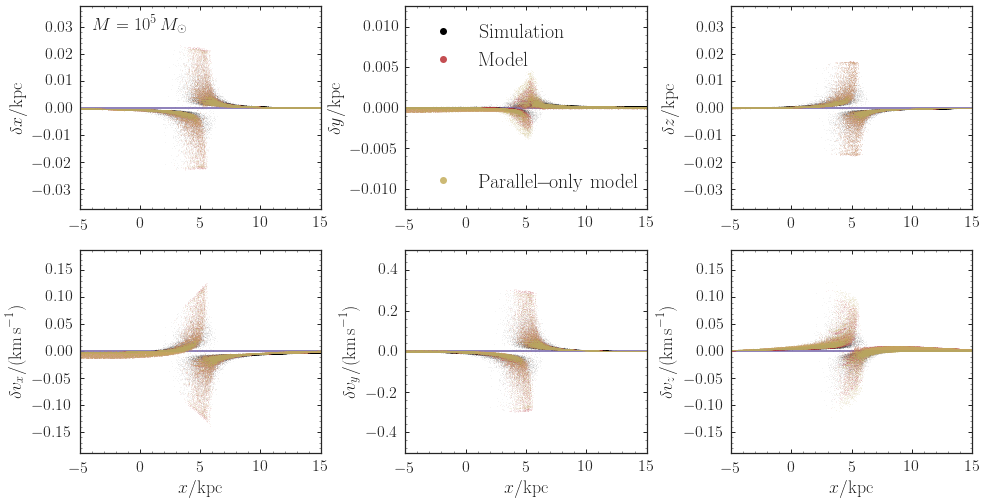

In [20]:
bovy_plot.bovy_print(axes_labelsize=18.,text_fontsize=12.,xtick_labelsize=16.,ytick_labelsize=16.)
figsize(16,8)
plot_single_comparison(xv_unp_peri,xv_1e5_peri,xv_mock_unp,xv_mock_per,xv_mock_per_onlyopar,5.)
if save_figures:
    plt.savefig(os.path.join(os.getenv('PAPERSDIR'),'2016-stream-stats','compare_nbody_single_1e5.pdf'),
                bbox_inches='tight')

# Multiple impacts

In [21]:
# Progenitor
xv_prog_init= numpy.array([30.,0.,0.,0., 105.74895, 105.74895])
RvR_prog_init= convert_to_cylindrical(xv_prog_init[:,numpy.newaxis].T)[0,:]
prog_init= Orbit([RvR_prog_init[0]/R0,RvR_prog_init[1]/V0,RvR_prog_init[2]/V0,
                  RvR_prog_init[3]/R0,RvR_prog_init[4]/V0,RvR_prog_init[5]],ro=R0,vo=V0)
times= numpy.linspace(0.,12./bovy_conversion.time_in_Gyr(V0,R0),1001)
prog_init.integrate(times,lp)
xv_unp_peri_prog= [prog_init.x(times[-1]),prog_init.y(times[-1]),prog_init.z(times[-1]),
              prog_init.vx(times[-1]),prog_init.vy(times[-1]),prog_init.vz(times[-1])]
RvR_unp_peri_prog= convert_to_cylindrical(numpy.array(xv_unp_peri_prog)[:,numpy.newaxis].T)[0,:]
prog_unp_peri= Orbit([RvR_unp_peri_prog[0]/R0,RvR_unp_peri_prog[1]/V0,RvR_unp_peri_prog[2]/V0,
                      RvR_unp_peri_prog[3]/R0+0.0,RvR_unp_peri_prog[4]/V0,RvR_unp_peri_prog[5]])

In [22]:
def plot_multi_comparison(xv_unp_peri,xv_1e6_peri,
                          xv_mock_unp,xv_mock_per,xv_mock_per_onlyopar,
                          log10mass,log10mass2,alpha=0.1):
    scale= 10.**(0.6*(log10mass-6.))
    gs=  gridspec.GridSpec(2,3,height_ratios=[1.,1.],hspace=0.2,wspace=0.35)
    gs2= gridspec.GridSpec(2,3,height_ratios=[1.,1.],hspace=0.2,wspace=0.35)
    subplot(gs2[0])
    bovy_plot.bovy_plot(sdf_smooth._ObsTrackXY[:,1]*R0,
                        sdf_smooth._ObsTrackXY[:,0]*R0*0.,
                        '-',color=sns.color_palette()[3],
                        ylabel=r'$\delta x/\mathrm{kpc}$',gcf=True,yrange=[-.08*scale,.08*scale],
                        xrange=[-14.,14.])
    plot(xv_unp_peri[(xv_unp_peri[:,0] < -10.),1],xv_1e6_peri[(xv_unp_peri[:,0] < -10.),0]
         -xv_unp_peri[(xv_unp_peri[:,0] < -10.),0],
         'k.',ms=1,alpha=alpha,rasterized=True)
    plot(xv_mock_unp[:,1]*R0,(xv_mock_per[:,0]-xv_mock_unp[:,0])*R0,'.',color=sns.color_palette()[2],
         ms=1.5,alpha=alpha,rasterized=True)
    plot(xv_mock_unp[:,1]*R0,(xv_mock_per_onlyopar[:,0]-xv_mock_unp[:,0])*R0,'.',
         color=sns.color_palette()[4],ms=1.5,alpha=alpha,rasterized=True)
    bovy_plot.bovy_text(r'$M = 10^%i\,M_\odot, M = 10^%i\,M_\odot$' % (log10mass,log10mass2),
                        size=18.,top_left=True)
    subplot(gs2[1])
    bovy_plot.bovy_plot(sdf_smooth._ObsTrackXY[:,1]*R0,
                        sdf_smooth._ObsTrackXY[:,0]*R0*0.,
                        '-',color=sns.color_palette()[3],
                        ylabel=r'$\delta y/\mathrm{kpc}$',gcf=True,yrange=[-.3*scale,.3*scale],
                        xrange=[-14.,14.])
    plot(xv_unp_peri[(xv_unp_peri[:,0] < -10.),1],xv_1e6_peri[(xv_unp_peri[:,0] < -10.),1]
         -xv_unp_peri[(xv_unp_peri[:,0] < -10.),1],
         'k.',ms=1,alpha=alpha,rasterized=True)
    plot(xv_mock_unp[:,1]*R0,(xv_mock_per[:,1]-xv_mock_unp[:,1])*R0,'.',color=sns.color_palette()[2],
         ms=1.5,alpha=alpha,rasterized=True)
    plot(xv_mock_unp[:,1]*R0,(xv_mock_per_onlyopar[:,1]-xv_mock_unp[:,1])*R0,'.',
         color=sns.color_palette()[4],ms=1.5,alpha=alpha,rasterized=True)
    l1= pyplot.legend((mlines.Line2D([], [], color='k',marker='o',ls='none'),
                       mlines.Line2D([], [], color=sns.color_palette()[2],marker='o',ls='none')),
                      (r'$\mathrm{Simulation}$',
                       r'$\mathrm{Model}$'),
                       loc='upper left',#bbox_to_anchor=(.02,.02),
                       numpoints=1,
                       prop={'size':20},
                       frameon=False)
    l2= pyplot.legend((mlines.Line2D([], [], color=sns.color_palette()[4],marker='o',ls='none'),),
                      (r'$\mathrm{Parallel\!\!-\!\!only\ model}$',),
                       loc='lower left',#bbox_to_anchor=(.02,.02),
                       numpoints=1,
                       prop={'size':20},
                       frameon=False)
    pyplot.gca().add_artist(l1)
    subplot(gs2[2])
    bovy_plot.bovy_plot(sdf_smooth._ObsTrackXY[:,1]*R0,
                        sdf_smooth._ObsTrackXY[:,0]*R0*0.,
                        '-',color=sns.color_palette()[3],
                        ylabel=r'$\delta z/\mathrm{kpc}$',gcf=True,yrange=[-.08*scale,.08*scale],
                        xrange=[-14.,14.])
    plot(xv_unp_peri[(xv_unp_peri[:,0] < -10.),1],xv_1e6_peri[(xv_unp_peri[:,0] < -10.),2]
         -xv_unp_peri[(xv_unp_peri[:,0] < -10.),2],
         'k.',ms=1,alpha=alpha,rasterized=True)
    plot(xv_mock_unp[:,1]*R0,(xv_mock_per[:,2]-xv_mock_unp[:,2])*R0,'.',color=sns.color_palette()[2],
         ms=1.5,alpha=alpha,rasterized=True)
    plot(xv_mock_unp[:,1]*R0,(xv_mock_per_onlyopar[:,2]-xv_mock_unp[:,2])*R0,'.',
         color=sns.color_palette()[4],ms=1.5,alpha=alpha,rasterized=True)
    subplot(gs2[3])
    bovy_plot.bovy_plot(sdf_smooth._ObsTrackXY[:,1]*R0,
                        sdf_smooth._ObsTrackXY[:,0]*R0*0.,
                        '-',xlabel=r'$y/\mathrm{kpc}$',color=sns.color_palette()[3],
                        ylabel=r'$\delta v_x/(\mathrm{km\,s}^{-1})$',gcf=True,yrange=[-1.5*scale,1.5*scale],
                        xrange=[-14.,14.])
    plot(xv_unp_peri[(xv_unp_peri[:,0] < -10.),1],xv_1e6_peri[(xv_unp_peri[:,0] < -10.),3]
         -xv_unp_peri[(xv_unp_peri[:,0] < -10.),3],
         'k.',ms=1,alpha=alpha,rasterized=True)
    plot(xv_mock_unp[:,1]*R0,(xv_mock_per[:,3]-xv_mock_unp[:,3])*V0,'.',color=sns.color_palette()[2],
         ms=1.5,alpha=alpha,rasterized=True)
    plot(xv_mock_unp[:,1]*R0,(xv_mock_per_onlyopar[:,3]-xv_mock_unp[:,3])*V0,'.',
         color=sns.color_palette()[4],ms=1.5,alpha=alpha,rasterized=True)
    subplot(gs2[4])
    bovy_plot.bovy_plot(sdf_smooth._ObsTrackXY[:,1]*R0,
                        sdf_smooth._ObsTrackXY[:,0]*R0*0.,
                        '-',xlabel=r'$y/\mathrm{kpc}$',color=sns.color_palette()[3],
                        ylabel=r'$\delta v_y/(\mathrm{km\,s}^{-1})$',gcf=True,yrange=[-0.35*scale,0.35*scale],
                        xrange=[-14.,14.])
    plot(xv_unp_peri[(xv_unp_peri[:,0] < -10.),1],xv_1e6_peri[(xv_unp_peri[:,0] < -10.),4]
         -xv_unp_peri[(xv_unp_peri[:,0] < -10.),4],
         'k.',ms=1,alpha=alpha,rasterized=True)
    plot(xv_mock_unp[:,1]*R0,(xv_mock_per[:,4]-xv_mock_unp[:,4])*V0,'.',color=sns.color_palette()[2],
         ms=1.5,alpha=alpha,rasterized=True)
    plot(xv_mock_unp[:,1]*R0,(xv_mock_per_onlyopar[:,4]-xv_mock_unp[:,4])*V0,'.',
         color=sns.color_palette()[4],ms=1.5,alpha=alpha,rasterized=True)
    subplot(gs2[5])
    bovy_plot.bovy_plot(sdf_smooth._ObsTrackXY[:,1]*R0,
                        sdf_smooth._ObsTrackXY[:,0]*R0*0.,
                        '-',xlabel=r'$y/\mathrm{kpc}$',color=sns.color_palette()[3],
                        ylabel=r'$\delta v_z/(\mathrm{km\,s}^{-1})$',gcf=True,yrange=[-1.5*scale,1.5*scale],
                        xrange=[-14.,14.])
    plot(xv_unp_peri[(xv_unp_peri[:,0] < -10.),1],xv_1e6_peri[(xv_unp_peri[:,0] < -10.),5]
         -xv_unp_peri[(xv_unp_peri[:,0] < -10.),5],
         'k.',ms=1,alpha=alpha,rasterized=True)
    plot(xv_mock_unp[:,1]*R0,(xv_mock_per[:,5]-xv_mock_unp[:,5])*V0,'.',color=sns.color_palette()[2],
         ms=1.5,alpha=alpha,rasterized=True)
    plot(xv_mock_unp[:,1]*R0,(xv_mock_per_onlyopar[:,5]-xv_mock_unp[:,5])*V0,'.',
         color=sns.color_palette()[4],ms=1.5,alpha=alpha,rasterized=True)

## Two $10^8\,M_\odot$ impacts

In [23]:
xvid= numpy.loadtxt(os.path.join(os.getenv('DATADIR'),'streamgap-aa','nonzeroJz',
                                 'snapshot_12000Myr_unperturbed.txt'))
xv_unp_12Gyr= xvid[:,:6]
xv_unp_12Gyr= xv_unp_12Gyr[numpy.argsort(xvid[:,6])]
RvR_unp_12Gyr= convert_to_cylindrical(xv_unp_12Gyr)
xvid= numpy.loadtxt(os.path.join(os.getenv('DATADIR'),'streamgap-aa','nonzeroJz',
                                 'snapshot_1e8Msun_1e8Msun_impact_12000Myr.txt'))
xv_1e8_12Gyr= xvid[:,:6]
xv_1e8_12Gyr= xv_1e8_12Gyr[numpy.argsort(xvid[:,6])]
RvR_1e8_12Gyr= convert_to_cylindrical(xv_1e8_12Gyr)

In [24]:
reload(custom_stripping_df)

<module 'custom_stripping_df' from 'custom_stripping_df.pyc'>

In [25]:
sigv= 0.365*(10./2.)**(1./3.) # km/s, based on M^(1/3) scaling applied to 10^5 vs. 2x10^4 in my paper
sdf_smooth= \
    custom_stripping_df.streamdf_jason(sigv/V0,progenitor=prog_unp_peri,pot=lp,aA=aAI,
#                                       leading=False,nTrackChunks=101,nTrackIterations=1,
                                       leading=False,nTrackChunks=11,nTrackIterations=1,
                                       sigMeanOffset=4.5,
                                       tdisrupt=12./bovy_conversion.time_in_Gyr(V0,R0),
                                       Vnorm=V0,Rnorm=R0)
sdf_1e81e8= \
   custom_stripping_df.streampepperdf_jason(sigv/V0,progenitor=prog_unp_peri,pot=lp,aA=aAI,
                                            leading=False,nTrackChunks=101,nTrackIterations=1,
                                            nTrackChunksImpact=116,sigMeanOffset=4.5,
#                                            leading=False,nTrackChunks=11,nTrackIterations=1,
#                                            nTrackChunksImpact=11,sigMeanOffset=4.5,
                                            tdisrupt=12.00/bovy_conversion.time_in_Gyr(V0,R0),
                                            Vnorm=V0,Rnorm=R0,
                                            impactb=[0.,0.],
                                            subhalovel=numpy.array([[6.82200571,132.7700529,149.4174464],
                                                                    [100.,0.,0.]])/V0, # from Denis' email
                                            timpact=[2./bovy_conversion.time_in_Gyr(V0,R0),
                                                     1./bovy_conversion.time_in_Gyr(V0,R0)],
                                            impact_angle=[-2.34,-2.44],
                                            GM=[10.**-2./bovy_conversion.mass_in_1010msol(V0,R0),
                                                10.**-2./bovy_conversion.mass_in_1010msol(V0,R0)],
                                            rs=[1.05/R0,1.05/R0])
sdf_1e81e8_onlyopar= \
   custom_stripping_df.streampepperdf_jason_onlyopar(sigv/V0,progenitor=prog_unp_peri,pot=lp,aA=aAI,
                                            leading=False,nTrackChunks=101,nTrackIterations=1,
                                            nTrackChunksImpact=116,sigMeanOffset=4.5,
#                                            leading=False,nTrackChunks=11,nTrackIterations=1,
#                                            nTrackChunksImpact=11,sigMeanOffset=4.5,
                                            tdisrupt=12.00/bovy_conversion.time_in_Gyr(V0,R0),
                                            Vnorm=V0,Rnorm=R0,
                                            impactb=[0.,0.],
                                            subhalovel=numpy.array([[6.82200571,132.7700529,149.4174464],
                                                                    [100.,0.,0.]])/V0, # from Denis' email
                                            timpact=[2./bovy_conversion.time_in_Gyr(V0,R0),
                                                     1./bovy_conversion.time_in_Gyr(V0,R0)],
                                            impact_angle=[-2.34,-2.44],
                                            GM=[10.**-2./bovy_conversion.mass_in_1010msol(V0,R0),
                                                10.**-2./bovy_conversion.mass_in_1010msol(V0,R0)],
                                            rs=[1.05/R0,1.05/R0]) 

In [26]:
sdf_1e81e8._useInterp= True
sdf_1e81e8_onlyopar._useInterp= True
numpy.random.seed(1)
xv_mock_unp= sdf_smooth.sample(n=100000,xy=True).T
numpy.random.seed(1) # Same seed, such that the mocks are the same, except for the kick
xv_mock_per= sdf_1e81e8.sample(n=100000,xy=True).T
numpy.random.seed(1) # Same seed, such that the mocks are the same, except for the kick
xv_mock_per_onlyopar= sdf_1e81e8_onlyopar.sample(n=100000,xy=True).T

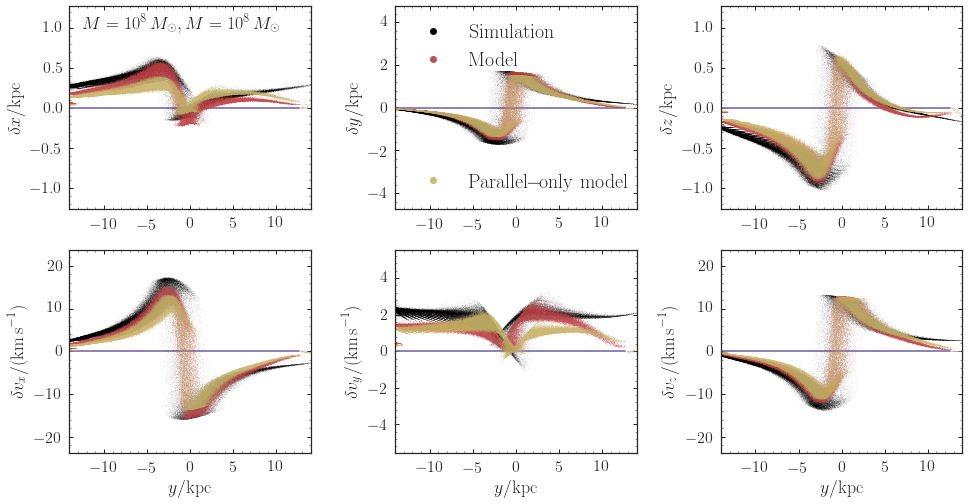

In [27]:
bovy_plot.bovy_print(axes_labelsize=18.,text_fontsize=12.,xtick_labelsize=16.,ytick_labelsize=16.)
figsize(16,8)
plot_multi_comparison(xv_unp_12Gyr,xv_1e8_12Gyr,xv_mock_unp,xv_mock_per,xv_mock_per_onlyopar,8.,8.)
if save_figures:
    plt.savefig(os.path.join(os.getenv('PAPERSDIR'),'2016-stream-stats','compare_nbody_multi_1e81e8.pdf'),
                bbox_inches='tight')

## One $10^8\,M_\odot$ and then one $10^7\,M_\odot$ impact

In [28]:
xvid= numpy.loadtxt(os.path.join(os.getenv('DATADIR'),'streamgap-aa','nonzeroJz',
                                 'snapshot_12000Myr_unperturbed.txt'))
xv_unp_12Gyr= xvid[:,:6]
xv_unp_12Gyr= xv_unp_12Gyr[numpy.argsort(xvid[:,6])]
RvR_unp_12Gyr= convert_to_cylindrical(xv_unp_12Gyr)
xvid= numpy.loadtxt(os.path.join(os.getenv('DATADIR'),'streamgap-aa','nonzeroJz',
                                 'snapshot_1e8Msun_1e7Msun_impact_12000Myr.txt'))
xv_1e7_12Gyr= xvid[:,:6]
xv_1e7_12Gyr= xv_1e7_12Gyr[numpy.argsort(xvid[:,6])]
RvR_1e7_12Gyr= convert_to_cylindrical(xv_1e7_12Gyr)

In [29]:
sigv= 0.365*(10./2.)**(1./3.) # km/s, based on M^(1/3) scaling applied to 10^5 vs. 2x10^4 in my paper
sdf_smooth= \
    custom_stripping_df.streamdf_jason(sigv/V0,progenitor=prog_unp_peri,pot=lp,aA=aAI,
#                                       leading=False,nTrackChunks=101,nTrackIterations=1,
                                       leading=False,nTrackChunks=11,nTrackIterations=1,
                                       sigMeanOffset=4.5,
                                       tdisrupt=12./bovy_conversion.time_in_Gyr(V0,R0),
                                       Vnorm=V0,Rnorm=R0)
sdf_1e81e7= \
   custom_stripping_df.streampepperdf_jason(sigv/V0,progenitor=prog_unp_peri,pot=lp,aA=aAI,
                                            leading=False,nTrackChunks=101,nTrackIterations=1,
                                            nTrackChunksImpact=116,sigMeanOffset=4.5,
#                                            leading=False,nTrackChunks=11,nTrackIterations=1,
#                                            nTrackChunksImpact=11,sigMeanOffset=4.5,
                                            tdisrupt=12.00/bovy_conversion.time_in_Gyr(V0,R0),
                                            Vnorm=V0,Rnorm=R0,
                                            impactb=[0.,0.],
                                            subhalovel=numpy.array([[6.82200571,132.7700529,149.4174464],
                                                                    [100.,0.,0.]])/V0, # from Denis' email
                                            timpact=[2./bovy_conversion.time_in_Gyr(V0,R0),
                                                     1./bovy_conversion.time_in_Gyr(V0,R0)],
                                            impact_angle=[-2.34,-2.44],
                                            GM=[10.**-2./bovy_conversion.mass_in_1010msol(V0,R0),
                                                10.**-3./bovy_conversion.mass_in_1010msol(V0,R0)],
                                            rs=[1.05/R0,1.05/R0])
sdf_1e81e7_onlyopar= \
   custom_stripping_df.streampepperdf_jason_onlyopar(sigv/V0,progenitor=prog_unp_peri,pot=lp,aA=aAI,
                                            leading=False,nTrackChunks=101,nTrackIterations=1,
                                            nTrackChunksImpact=116,sigMeanOffset=4.5,
#                                            leading=False,nTrackChunks=11,nTrackIterations=1,
#                                            nTrackChunksImpact=11,sigMeanOffset=4.5,
                                            tdisrupt=12.00/bovy_conversion.time_in_Gyr(V0,R0),
                                            Vnorm=V0,Rnorm=R0,
                                            impactb=[0.,0.],
                                            subhalovel=numpy.array([[6.82200571,132.7700529,149.4174464],
                                                                    [100.,0.,0.]])/V0, # from Denis' email
                                            timpact=[2./bovy_conversion.time_in_Gyr(V0,R0),
                                                     1./bovy_conversion.time_in_Gyr(V0,R0)],
                                            impact_angle=[-2.34,-2.44],
                                            GM=[10.**-2./bovy_conversion.mass_in_1010msol(V0,R0),
                                                10.**-3./bovy_conversion.mass_in_1010msol(V0,R0)],
                                            rs=[1.05/R0,0.332/R0]) 

In [30]:
sdf_1e81e7._useInterp= True
sdf_1e81e7_onlyopar._useInterp= True
numpy.random.seed(1)
xv_mock_unp= sdf_smooth.sample(n=100000,xy=True).T
numpy.random.seed(1) # Same seed, such that the mocks are the same, except for the kick
xv_mock_per= sdf_1e81e7.sample(n=100000,xy=True).T
numpy.random.seed(1) # Same seed, such that the mocks are the same, except for the kick
xv_mock_per_onlyopar= sdf_1e81e7_onlyopar.sample(n=100000,xy=True).T

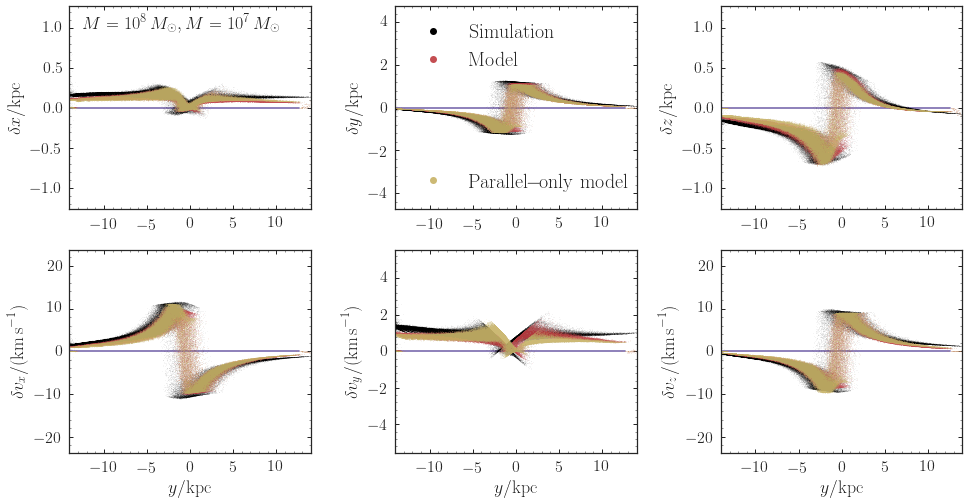

In [31]:
bovy_plot.bovy_print(axes_labelsize=18.,text_fontsize=12.,xtick_labelsize=16.,ytick_labelsize=16.)
figsize(16,8)
plot_multi_comparison(xv_unp_12Gyr,xv_1e7_12Gyr,xv_mock_unp,xv_mock_per,xv_mock_per_onlyopar,8.,7.)
if save_figures:
    plt.savefig(os.path.join(os.getenv('PAPERSDIR'),'2016-stream-stats','compare_nbody_multi_1e81e7.pdf'),
                bbox_inches='tight')

#Comparison with many impacts

In [32]:
# Progenitor
xv_prog_init= numpy.array([30.,0.,0.,0., 105.74895, 105.74895])
RvR_prog_init= convert_to_cylindrical(xv_prog_init[:,numpy.newaxis].T)[0,:]
prog_init= Orbit([RvR_prog_init[0]/R0,RvR_prog_init[1]/V0,RvR_prog_init[2]/V0,
                  RvR_prog_init[3]/R0,RvR_prog_init[4]/V0,RvR_prog_init[5]],ro=R0,vo=V0)
times= numpy.linspace(0.,12./bovy_conversion.time_in_Gyr(V0,R0),1001)
prog_init.integrate(times,lp)
xv_unp_peri_prog= [prog_init.x(times[-1]),prog_init.y(times[-1]),prog_init.z(times[-1]),
              prog_init.vx(times[-1]),prog_init.vy(times[-1]),prog_init.vz(times[-1])]
RvR_unp_peri_prog= convert_to_cylindrical(numpy.array(xv_unp_peri_prog)[:,numpy.newaxis].T)[0,:]
prog_unp_peri= Orbit([RvR_unp_peri_prog[0]/R0,RvR_unp_peri_prog[1]/V0,RvR_unp_peri_prog[2]/V0,
                      RvR_unp_peri_prog[3]/R0+0.0,RvR_unp_peri_prog[4]/V0,RvR_unp_peri_prog[5]])

## Sample many impacts

In [33]:
sigv= 0.365*(10./2.)**(1./3.) # km/s, based on M^(1/3) scaling applied to 10^5 vs. 2x10^4 in my paper
sdf_smooth= \
    custom_stripping_df.streamdf_jason(sigv/V0,progenitor=prog_unp_peri,pot=lp,aA=aAI,
#                                       leading=False,nTrackChunks=101,nTrackIterations=1,
                                       leading=False,nTrackChunks=11,nTrackIterations=1,
                                       sigMeanOffset=4.5,
                                       tdisrupt=12./bovy_conversion.time_in_Gyr(V0,R0),
                                       Vnorm=V0,Rnorm=R0)

In [34]:
massrange=[6.,8.]
plummer= False
Xrs= 5.
nsubhalo= simulate_streampepper.nsubhalo
rs= simulate_streampepper.rs
dNencdm= simulate_streampepper.dNencdm
sample_GM= lambda: (10.**((-0.5)*massrange[0])\
                                    +(10.**((-0.5)*massrange[1])\
                                          -10.**((-0.5)*massrange[0]))\
                                    *numpy.random.uniform())**(1./(-0.5))\
                                    /bovy_conversion.mass_in_msol(V0,R0)
rate_range= numpy.arange(massrange[0]+0.5,massrange[1]+0.5,1)
rate= numpy.sum([dNencdm(sdf_smooth,10.**r,Xrs=Xrs,
                                plummer=plummer)
                        for r in rate_range])
sample_rs= lambda x: rs(x*bovy_conversion.mass_in_1010msol(V0,R0)*10.**10.,
                            plummer=plummer)

In [35]:
# Setup the rate for impacts between 10 and 12 Gyr and the times
tmin, tmax= 10., 11.75
adjust_rate= rate*(tmax**2.-tmin**2.)/12.**2.
nsam= 24
setup_times= [float(12.-ti)/bovy_conversion.time_in_Gyr(V0,R0)
                for ti in numpy.arange(1,nsam+1)/(nsam+1.)*(tmax-tmin)+tmin]
print numpy.array(setup_times)*bovy_conversion.time_in_Gyr(V0,R0)

[ 1.93  1.86  1.79  1.72  1.65  1.58  1.51  1.44  1.37  1.3   1.23  1.16
  1.09  1.02  0.95  0.88  0.81  0.74  0.67  0.6   0.53  0.46  0.39  0.32]


In [36]:
pepperfilename= 'nbodypepper.pkl'
if os.path.exists(pepperfilename):
    with open(pepperfilename,'rb') as savefile:
        sdf_pepper= pickle.load(savefile)
else:
    sdf_pepper= streampepperdf.streampepperdf(sigv/V0,progenitor=prog_unp_peri,pot=lp,aA=aAI,
                           leading=False,nTrackChunks=11,nTrackIterations=1,
                           nTrackChunksImpact=116,sigMeanOffset=4.5,
                           tdisrupt=12./bovy_conversion.time_in_Gyr(V0,R0),
                           Vnorm=V0,Rnorm=R0,
                           timpact=setup_times,
                           spline_order=1,
                           hernquist=not plummer)
    save_pickles(pepperfilename,sdf_pepper)

In [37]:
def compute_impact_position(sdf_pepper,timpact,impactb,impact_angle,subhalovel):
    """From a given impact parameter, compute a full 3D impact point"""
    # Generate x, y, and z in the cylindrical frame centered on the stream at impact
    # (x,z) must be perpendicular to (vx,vz), both wrt the stream
    # Get stream direction to get (vx,vz) wrt the stream
    sdf_pepper._sgapdfs_coordtransform[timpact]._impact_angle= impact_angle
    sdf_pepper._sgapdfs_coordtransform[timpact]\
        ._interpolate_stream_track_kick()
    streamDir= numpy.array([sdf_pepper._sgapdfs_coordtransform[timpact]\
                                ._kick_interpTrackvX(impact_angle),
                            sdf_pepper._sgapdfs_coordtransform[timpact]\
                                ._kick_interpTrackvY(impact_angle),
                            sdf_pepper._sgapdfs_coordtransform[timpact]\
                                ._kick_interpTrackvZ(impact_angle)])
    streamDir/= numpy.sqrt(numpy.sum(streamDir**2.))
    # Find other unit vectors
    streamXDir= numpy.cross(streamDir,[0,1,0])
    streamXDir/= numpy.sqrt(numpy.sum(streamXDir**2.))
    streamZDir= numpy.cross(streamDir,streamXDir)
    streamZDir/= numpy.sqrt(numpy.sum(streamZDir**2.))
    streamPos= numpy.array([sdf_pepper._sgapdfs_coordtransform[timpact]\
                                ._kick_interpTrackX(impact_angle),
                            sdf_pepper._sgapdfs_coordtransform[timpact]\
                                ._kick_interpTrackY(impact_angle),
                            sdf_pepper._sgapdfs_coordtransform[timpact]\
                                ._kick_interpTrackZ(impact_angle)],dtype='float')
    # Get subhalovel in this coordinate frame
    relvel= subhalovel-numpy.array([sdf_pepper._sgapdfs_coordtransform[timpact]\
                                    ._kick_interpTrackvX(impact_angle),
                                sdf_pepper._sgapdfs_coordtransform[timpact]\
                                    ._kick_interpTrackvY(impact_angle),
                                sdf_pepper._sgapdfs_coordtransform[timpact]\
                                    ._kick_interpTrackvZ(impact_angle)],dtype='float')
    vx= numpy.dot(relvel,streamXDir)
    vz= numpy.dot(relvel,streamZDir)
    costheta=  vz/numpy.sqrt(vx**2.+vz**2.)
    sintheta=  -vx/numpy.sqrt(vx**2.+vz**2.)
    x= impactb*costheta
    z= impactb*sintheta
    return streamPos-x*streamXDir-z*streamZDir

In [38]:
# simulate impacts
numpy.random.seed(4)
sdf_pepper.simulate(rate=adjust_rate,
                    sample_GM=sample_GM,sample_rs=sample_rs,Xrs=Xrs)
nimpact= len(sdf_pepper._impact_angle)
subhaloposs= numpy.empty((nimpact,3))
for ii in range(nimpact):
    subhaloposs[ii]=\
        compute_impact_position(sdf_pepper,
                                sdf_pepper._timpact[ii],
                                sdf_pepper._impactb[ii],
                                -sdf_pepper._impact_angle[ii],
                                sdf_pepper._subhalovel[ii])

In [39]:
# Print the impact parameters
print sdf_pepper._impact_angle
print 12.-sdf_pepper._timpact*bovy_conversion.time_in_Gyr(V0,R0)
print sdf_pepper._GM*bovy_conversion.mass_in_1010msol(V0,R0)*100.
print sdf_pepper._rs*R0
print sdf_pepper._impactb*R0
print sdf_pepper._subhalovel*V0
print subhaloposs*R0

[-2.81953783 -2.22665127 -1.14125848 -1.6590854  -1.10251343 -1.70559464
 -1.22432614 -1.80108562 -1.74809102 -1.57611917 -0.42221838 -0.98083585
 -0.26065225 -2.43957245 -1.65229671 -1.903862   -1.99083032 -0.53071155
 -1.38280239 -0.55010477 -0.45677629 -1.35418588 -1.86363157 -1.59321997]
[ 11.68  11.68  11.68  11.61  11.47  11.47  11.47  11.4   11.33  11.12
  11.12  11.05  11.05  10.77  10.77  10.49  10.42  10.42  10.35  10.28
  10.14  10.14  10.07  10.07]
[ 0.01431516  0.04647158  0.17491951  0.04792492  0.03786059  0.03471147
  0.02029534  0.02560809  0.33237246  0.19737799  0.05007167  0.04675753
  0.02675505  0.01128277  0.04249932  0.01280439  0.08616734  0.15643732
  0.28967596  0.26348773  0.01171763  0.0164749   0.02474879  0.03282048]
[ 0.12562827  0.2263513   0.43914549  0.2298635   0.20430689  0.19562565
  0.14958481  0.16802653  0.6053434   0.46648604  0.23495534  0.22704664
  0.1717482   0.11153139  0.21646132  0.11881432  0.30821988  0.41529765
  0.56512631  0.5389760

In [40]:
# Test that the subhalopos is impactb away from the stream and that the fly-by
# velocity is perpendicular to the flyby position
for nindx in range(len(subhaloposs)):
    ttimpact= sdf_pepper._timpact[nindx]
    timpact_angle= -sdf_pepper._impact_angle[nindx]
    streamPos= numpy.array([sdf_pepper._sgapdfs_coordtransform[ttimpact]\
                                ._kick_interpTrackX(timpact_angle),
                            sdf_pepper._sgapdfs_coordtransform[ttimpact]\
                                ._kick_interpTrackY(timpact_angle),
                            sdf_pepper._sgapdfs_coordtransform[ttimpact]\
                                ._kick_interpTrackZ(timpact_angle)])
    streamDir= numpy.array([sdf_pepper._sgapdfs_coordtransform[ttimpact]\
                                ._kick_interpTrackvX(timpact_angle),
                            sdf_pepper._sgapdfs_coordtransform[ttimpact]\
                                ._kick_interpTrackvY(timpact_angle),
                            sdf_pepper._sgapdfs_coordtransform[ttimpact]\
                                ._kick_interpTrackvZ(timpact_angle)])
    streamDir/= numpy.sqrt(numpy.sum(streamDir**2.)) # normalize
    diff= subhaloposs[nindx]-streamPos
    assert numpy.fabs(numpy.dot(diff,streamDir)/numpy.sqrt(numpy.sum(diff**2.))) < 10.**-12., \
        'subhalo position not perpendicular to stream'
    streamVel= numpy.array([sdf_pepper._sgapdfs_coordtransform[ttimpact]\
                                ._kick_interpTrackvX(timpact_angle),
                            sdf_pepper._sgapdfs_coordtransform[ttimpact]\
                                ._kick_interpTrackvY(timpact_angle),
                            sdf_pepper._sgapdfs_coordtransform[ttimpact]\
                                ._kick_interpTrackvZ(timpact_angle)])
    diffv= sdf_pepper._subhalovel[nindx]-streamVel
    assert numpy.fabs(numpy.dot(diff,diffv)/numpy.sqrt(numpy.dot(diff,diff)*numpy.dot(diffv,diffv))) < 10.**-12.,\
        'subhalo position offset not perpendicular to velocity'

In [41]:
# Store
impact_angle= sdf_pepper._impact_angle
timpact= sdf_pepper._timpact
GM= sdf_pepper._GM
rs= sdf_pepper._rs
impactb= sdf_pepper._impactb
subhalovel= sdf_pepper._subhalovel

## Compare many impact case to $N$-body simulation

In [42]:
def plot_many_comparison(xv_unp_peri,xv_1e6_peri,
                         xv_mock_unp,xv_mock_per,xv_mock_per_onlyopar,
                         RvR_unp_peri,RvR_1e6_peri,
                         RvR_mock_unp,RvR_mock_per,RvR_mock_per_onlyopar,
                         alpha=0.1):
    gs=  gridspec.GridSpec(2,3,height_ratios=[1.,1.],hspace=0.2,wspace=0.35)
    gs2= gridspec.GridSpec(2,3,height_ratios=[1.,1.],hspace=0.2,wspace=0.35)
    subplot(gs2[0])
    bovy_plot.bovy_plot(sdf_smooth._ObsTrack[:,5]*180./numpy.pi,
                        sdf_smooth._ObsTrackXY[:,0]*R0*0.,
                        '-',color=sns.color_palette()[3],
                        ylabel=r'$\delta x/\mathrm{kpc}$',gcf=True,yrange=[-2.,2.],
                        xrange=[120.,240.])
    sindx= RvR_unp_12Gyr[:,5]*180./numpy.pi < numpy.median(RvR_unp_12Gyr[:,5])*180./numpy.pi-5.
    plot(RvR_unp_peri[sindx,5]*180./numpy.pi,xv_1e6_peri[sindx,0]-xv_unp_peri[sindx,0],
         'k.',ms=1,alpha=alpha,rasterized=True)
    plot(RvR_mock_unp[:,5]*180./numpy.pi,(xv_mock_per[:,0]-xv_mock_unp[:,0])*R0,
         '.',color=sns.color_palette()[2],
         ms=1.5,alpha=alpha,rasterized=True)
    plot(RvR_mock_unp[:,5]*180./numpy.pi,(xv_mock_per_onlyopar[:,0]-xv_mock_unp[:,0])*R0,
         '.',color=sns.color_palette()[4],ms=1.5,alpha=alpha,rasterized=True)
    subplot(gs2[1])
    bovy_plot.bovy_plot(sdf_smooth._ObsTrack[:,5]*180./numpy.pi,
                        sdf_smooth._ObsTrackXY[:,1]*R0*0.,
                        '-',color=sns.color_palette()[3],
                        ylabel=r'$\delta y/\mathrm{kpc}$',gcf=True,yrange=[-2.,2.],
                        xrange=[120.,240.])
    plot(RvR_unp_peri[sindx,5]*180./numpy.pi,xv_1e6_peri[sindx,1]-xv_unp_peri[sindx,1],
         'k.',ms=1,alpha=alpha,rasterized=True)
    plot(RvR_mock_unp[:,5]*180./numpy.pi,(xv_mock_per[:,1]-xv_mock_unp[:,1])*R0,
         '.',color=sns.color_palette()[2],
         ms=1.5,alpha=alpha,rasterized=True)
    plot(RvR_mock_unp[:,5]*180./numpy.pi,(xv_mock_per_onlyopar[:,1]-xv_mock_unp[:,1])*R0,
         '.',color=sns.color_palette()[4],ms=1.5,alpha=alpha,rasterized=True)    
    l1= pyplot.legend((mlines.Line2D([], [], color='k',marker='o',ls='none'),
                       mlines.Line2D([], [], color=sns.color_palette()[2],marker='o',ls='none')),
                      (r'$\mathrm{Simulation}$',
                       r'$\mathrm{Model}$'),
                       loc='upper left',#bbox_to_anchor=(.02,.02),
                       numpoints=1,
                       prop={'size':20},
                       frameon=False)
    l2= pyplot.legend((mlines.Line2D([], [], color=sns.color_palette()[4],marker='o',ls='none'),),
                      (r'$\mathrm{Parallel\!\!-\!\!only\ model}$',),
                       loc='lower left',#bbox_to_anchor=(.02,.02),
                       numpoints=1,
                       prop={'size':20},
                       frameon=False)
    pyplot.gca().add_artist(l1)
    subplot(gs2[2])
    bovy_plot.bovy_plot(sdf_smooth._ObsTrack[:,5]*180./numpy.pi,
                        sdf_smooth._ObsTrackXY[:,0]*R0*0.,
                        '-',color=sns.color_palette()[3],
                        ylabel=r'$\delta z/\mathrm{kpc}$',gcf=True,yrange=[-2.,2.],
                        xrange=[120.,240.])
    plot(RvR_unp_peri[sindx,5]*180./numpy.pi,xv_1e6_peri[sindx,2]-xv_unp_peri[sindx,2],
         'k.',ms=1,alpha=alpha,rasterized=True)
    plot(RvR_mock_unp[:,5]*180./numpy.pi,(xv_mock_per[:,2]-xv_mock_unp[:,2])*R0,
         '.',color=sns.color_palette()[2],
         ms=1.5,alpha=alpha,rasterized=True)
    plot(RvR_mock_unp[:,5]*180./numpy.pi,(xv_mock_per_onlyopar[:,2]-xv_mock_unp[:,2])*R0,
         '.',color=sns.color_palette()[4],ms=1.5,alpha=alpha,rasterized=True)
    subplot(gs2[3])
    bovy_plot.bovy_plot(sdf_smooth._ObsTrack[:,5]*180./numpy.pi,
                        sdf_smooth._ObsTrackXY[:,3]*R0*0.,
                        '-',color=sns.color_palette()[3],
                        xlabel=r'$\phi/\mathrm{deg}$',
                        ylabel=r'$\delta v_x/(\mathrm{km\,s}^{-1})$',gcf=True,yrange=[-25,25],
                        xrange=[120.,240.])
    plot(RvR_unp_peri[sindx,5]*180./numpy.pi,xv_1e6_peri[sindx,3]-xv_unp_peri[sindx,3],
         'k.',ms=1,alpha=alpha,rasterized=True)
    plot(RvR_mock_unp[:,5]*180./numpy.pi,(xv_mock_per[:,3]-xv_mock_unp[:,3])*V0,
         '.',color=sns.color_palette()[2],
         ms=1.5,alpha=alpha,rasterized=True)
    plot(RvR_mock_unp[:,5]*180./numpy.pi,(xv_mock_per_onlyopar[:,3]-xv_mock_unp[:,3])*V0,
         '.',color=sns.color_palette()[4],ms=1.5,alpha=alpha,rasterized=True)
    subplot(gs2[4])
    bovy_plot.bovy_plot(sdf_smooth._ObsTrack[:,5]*180./numpy.pi,
                        sdf_smooth._ObsTrackXY[:,3]*R0*0.,
                        '-',color=sns.color_palette()[3],
                        xlabel=r'$\phi/\mathrm{deg}$',
                        ylabel=r'$\delta v_y/(\mathrm{km\,s}^{-1})$',gcf=True,yrange=[-25,25],
                        xrange=[120.,240.])
    plot(RvR_unp_peri[sindx,5]*180./numpy.pi,xv_1e6_peri[sindx,4]-xv_unp_peri[sindx,4],
         'k.',ms=1,alpha=alpha,rasterized=True)
    plot(RvR_mock_unp[:,5]*180./numpy.pi,(xv_mock_per[:,4]-xv_mock_unp[:,4])*V0,
         '.',color=sns.color_palette()[2],
         ms=1.5,alpha=alpha,rasterized=True)
    plot(RvR_mock_unp[:,5]*180./numpy.pi,(xv_mock_per_onlyopar[:,4]-xv_mock_unp[:,4])*V0,
         '.',color=sns.color_palette()[4],ms=1.5,alpha=alpha,rasterized=True)
    subplot(gs2[5])
    bovy_plot.bovy_plot(sdf_smooth._ObsTrack[:,5]*180./numpy.pi,
                        sdf_smooth._ObsTrackXY[:,3]*R0*0.,
                        '-',color=sns.color_palette()[3],
                        xlabel=r'$\phi/\mathrm{deg}$',
                        ylabel=r'$\delta v_x/(\mathrm{km\,s}^{-1})$',gcf=True,yrange=[-25,25],
                        xrange=[120.,240.])
    plot(RvR_unp_peri[sindx,5]*180./numpy.pi,xv_1e6_peri[sindx,5]-xv_unp_peri[sindx,5],
         'k.',ms=1,alpha=alpha,rasterized=True)
    plot(RvR_mock_unp[:,5]*180./numpy.pi,(xv_mock_per[:,5]-xv_mock_unp[:,5])*V0,
         '.',color=sns.color_palette()[2],
         ms=1.5,alpha=alpha,rasterized=True)
    plot(RvR_mock_unp[:,5]*180./numpy.pi,(xv_mock_per_onlyopar[:,5]-xv_mock_unp[:,5])*V0,
         '.',color=sns.color_palette()[4],ms=1.5,alpha=alpha,rasterized=True)

In [43]:
xvid= numpy.loadtxt(os.path.join(os.getenv('DATADIR'),'streamgap-aa','nonzeroJz',
                                 'snapshot_12000Myr_unperturbed.txt'))
xv_unp_12Gyr= xvid[:,:6]
xv_unp_12Gyr= xv_unp_12Gyr[numpy.argsort(xvid[:,6])]
RvR_unp_12Gyr= convert_to_cylindrical(xv_unp_12Gyr)
xvid= numpy.loadtxt(os.path.join(os.getenv('DATADIR'),'streamgap-aa','nonzeroJz',
                                 'snapshot_12000Myr_24_impacts_II.txt'))
xv_24impacts_12Gyr= xvid[:,:6]
xv_24impacts_12Gyr= xv_24impacts_12Gyr[numpy.argsort(xvid[:,6])]
RvR_24impacts_12Gyr= convert_to_cylindrical(xv_24impacts_12Gyr)

In [44]:
sigv= 0.365*(10./2.)**(1./3.) # km/s, based on M^(1/3) scaling applied to 10^5 vs. 2x10^4 in my paper
sdf_smooth= \
    custom_stripping_df.streamdf_jason(sigv/V0,progenitor=prog_unp_peri,pot=lp,aA=aAI,
                                       leading=False,nTrackChunks=11,nTrackIterations=1,
                                       sigMeanOffset=4.5,
                                       tdisrupt=12./bovy_conversion.time_in_Gyr(V0,R0),
                                       Vnorm=V0,Rnorm=R0)
sdf_many= \
   custom_stripping_df.streampepperdf_jason(sigv/V0,progenitor=prog_unp_peri,pot=lp,aA=aAI,
                                            leading=False,nTrackChunks=101,nTrackIterations=1,
                                            nTrackChunksImpact=116,sigMeanOffset=4.5,
                                            tdisrupt=12.00/bovy_conversion.time_in_Gyr(V0,R0),
                                            Vnorm=V0,Rnorm=R0,
                                            impactb=sdf_pepper._impactb,
                                            subhalovel=sdf_pepper._subhalovel,
                                            timpact=sdf_pepper._timpact,
                                            impact_angle=sdf_pepper._impact_angle,
                                            GM=sdf_pepper._GM,
                                            rs=sdf_pepper._rs,hernquist=True)
sdf_many_onlyopar= \
   custom_stripping_df.streampepperdf_jason_onlyopar(sigv/V0,progenitor=prog_unp_peri,pot=lp,aA=aAI,
                                            leading=False,nTrackChunks=101,nTrackIterations=1,
                                            nTrackChunksImpact=116,sigMeanOffset=4.5,
                                            tdisrupt=12.00/bovy_conversion.time_in_Gyr(V0,R0),
                                            Vnorm=V0,Rnorm=R0,
                                            impactb=sdf_pepper._impactb,
                                            subhalovel=sdf_pepper._subhalovel,
                                            timpact=sdf_pepper._timpact,
                                            impact_angle=sdf_pepper._impact_angle,
                                            GM=sdf_pepper._GM,
                                            rs=sdf_pepper._rs,hernquist=True)

In [45]:
sdf_many.hernquist= True
sdf_many._sgapdfs_coordtransform= sdf_pepper._sgapdfs_coordtransform
sdf_many.set_impacts(impact_angle=sdf_pepper._impact_angle,
                     impactb=sdf_pepper._impactb,
                     subhalovel=sdf_pepper._subhalovel,
                     timpact=sdf_pepper._timpact,
                     GM=sdf_pepper._GM,rs=sdf_pepper._rs)
sdf_many_onlyopar.hernquist= True
sdf_many_onlyopar._sgapdfs_coordtransform= sdf_pepper._sgapdfs_coordtransform
sdf_many_onlyopar.set_impacts(impact_angle=sdf_pepper._impact_angle,
                         impactb=sdf_pepper._impactb,
                         subhalovel=sdf_pepper._subhalovel,
                         timpact=sdf_pepper._timpact,
                         GM=sdf_pepper._GM,rs=sdf_pepper._rs)

In [46]:
sdf_many._useInterp= True
sdf_many_onlyopar._useInterp= True
numpy.random.seed(1)
xv_mock_unp= sdf_smooth.sample(n=1000000,xy=True).T
RvR_mock_unp= convert_to_cylindrical(xv_mock_unp)
numpy.random.seed(1) # Same seed, such that the mocks are the same, except for the kick
xv_mock_per= sdf_many.sample(n=1000000,xy=True).T
RvR_mock_per= convert_to_cylindrical(xv_mock_per)
numpy.random.seed(1) # Same seed, such that the mocks are the same, except for the kick
xv_mock_per_onlyopar= sdf_many_onlyopar.sample(n=1000000,xy=True).T
RvR_mock_per_onlyopar= convert_to_cylindrical(xv_mock_per_onlyopar)

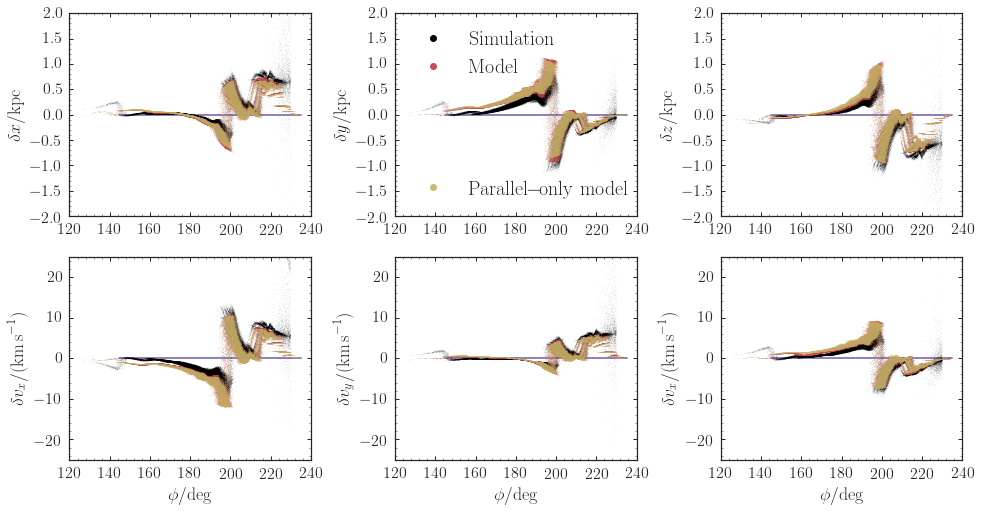

In [47]:
bovy_plot.bovy_print(axes_labelsize=18.,text_fontsize=12.,xtick_labelsize=16.,ytick_labelsize=16.)
figsize(16,8)
plot_many_comparison(xv_unp_12Gyr,xv_24impacts_12Gyr,xv_mock_unp[::10],xv_mock_per[::10],xv_mock_per_onlyopar[::10],
                     RvR_unp_12Gyr,RvR_24impacts_12Gyr,
                     RvR_mock_unp[::10],RvR_mock_per[::10],RvR_mock_per_onlyopar[::10])
if save_figures:
    plt.savefig(os.path.join(os.getenv('PAPERSDIR'),'2016-stream-stats','compare_nbody_24impacts.pdf'),
                bbox_inches='tight')

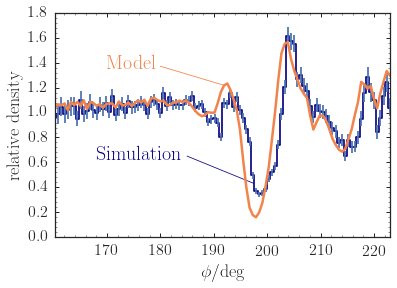

In [48]:
bovy_plot.bovy_print(axes_labelsize=18.,text_fontsize=12.,xtick_labelsize=16.,ytick_labelsize=16.)
figsize(6,4)
bins= 201
h, e= numpy.histogram(RvR_unp_12Gyr[RvR_unp_12Gyr[:,5]*180./numpy.pi \
                                    < numpy.median(RvR_unp_12Gyr[:,5])*180./numpy.pi-5.,
                        5]*180./numpy.pi,
          bins=bins,range=[120.,240.])
h2, e= numpy.histogram(RvR_24impacts_12Gyr[RvR_unp_12Gyr[:,5]*180./numpy.pi \
                                           < numpy.median(RvR_unp_12Gyr[:,5])*180./numpy.pi-5.,
                        5]*180./numpy.pi,
          bins=bins,range=[120.,240.])
err= h2.astype('float')/h*numpy.sqrt(1./h2+1./h)
hm, e= numpy.histogram(RvR_mock_unp[:,5]*180./numpy.pi,
          bins=bins,range=[120.,240.])
h2m, e= numpy.histogram(RvR_mock_per[:,5]*180./numpy.pi,
          bins=bins,range=[120.,240.])
errm= h2m.astype('float')/hm*numpy.sqrt(1./h2m+1./hm)
p= ((numpy.roll(e,1)+e)/2.)[1:]
indx= (p > 160.)*(p < 223.)
bovy_plot.bovy_plot(p[indx],(h2.astype('float')/h)[indx],
                    ls='steps-mid',color=cm.plasma(0.),lw=1.75,
                    xlabel=r'$\phi/\mathrm{deg}$',
                    ylabel=r'$\mathrm{relative\ density}$',
                    yrange=[0.,1.8],zorder=1)
errorbar(p[indx],(h2.astype('float')/h)[indx],err[indx],
         marker='None',ls='None')
plot(p[indx],(h2m.astype('float')/hm)[indx],color=cm.plasma(0.7),ls='-',lw=2.5,zorder=2)
# Label the curves
plot([192.,180],[1.22,1.375],color=cm.plasma(0.7),lw=.8,zorder=0)
bovy_plot.bovy_text(170.,1.35,r'$\mathrm{Model}$',size=20.,color=cm.plasma(0.7))
plot([197.5,185],[0.43,0.65],color=cm.plasma(0.),lw=.8,zorder=0)
bovy_plot.bovy_text(168.,0.62,r'$\mathrm{Simulation}$',size=20.,color=cm.plasma(0.))
if save_figures:
    plt.savefig(os.path.join(os.getenv('PAPERSDIR'),'2016-stream-stats','compare_nbody_24impacts_dens.pdf'),
                bbox_inches='tight')

The actual density is

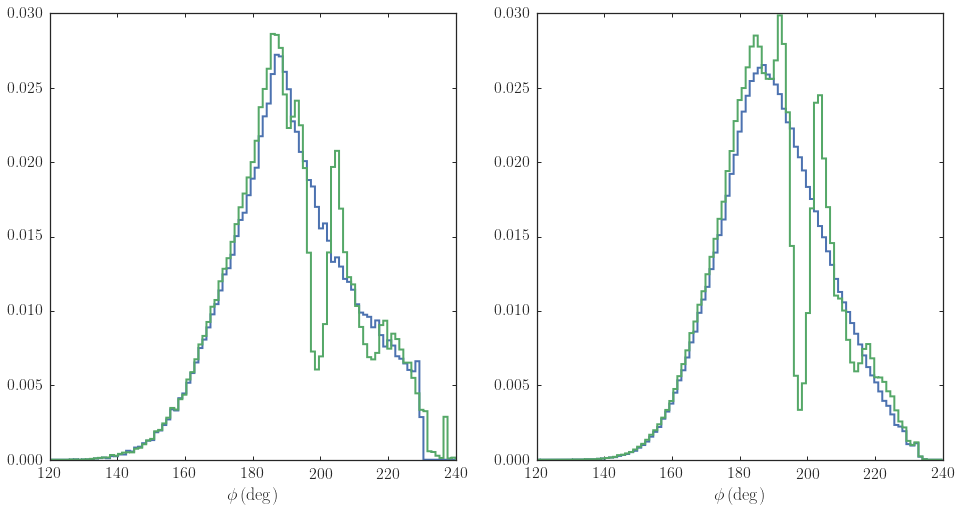

In [49]:
figsize(16,8)
bins= 101
subplot(1,2,1)
h, e, p= hist(RvR_unp_12Gyr[RvR_unp_12Gyr[:,5]*180./numpy.pi < numpy.median(RvR_unp_12Gyr[:,5])*180./numpy.pi-5.,
                        5]*180./numpy.pi,
          bins=bins,range=[120.,240.],histtype='step',normed=True,lw=2.)
h2, e, p= hist(RvR_24impacts_12Gyr[RvR_unp_12Gyr[:,5]*180./numpy.pi < numpy.median(RvR_unp_12Gyr[:,5])*180./numpy.pi-5.,
                        5]*180./numpy.pi,
          bins=bins,range=[120.,240.],histtype='step',normed=True,lw=2.)
xlabel(r'$\phi\,(\mathrm{deg})$')
subplot(1,2,2)
hm, e, p= hist(RvR_mock_unp[:,5]*180./numpy.pi,
          bins=bins,range=[120.,240.],histtype='step',normed=True,lw=2.)
hm2, e, p= hist(RvR_mock_per[:,5]*180./numpy.pi,
          bins=bins,range=[120.,240.],histtype='step',normed=True,lw=2.)
xlabel(r'$\phi\,(\mathrm{deg})$')

The power spectra are quite similar:

(0.06, 10.0)

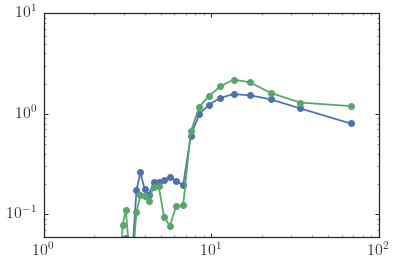

In [51]:
figsize(6,4)
p= ((numpy.roll(e,1)+e)/2.)[1:]
indx= (p > 160.)*(p < 228.)
scaling= 'spectrum'
tdata= (h2/h)[indx]
ll= p
px, py= signal.csd(tdata,tdata,
                   fs=1./(ll[1]-ll[0]),scaling=scaling,
                   nperseg=len(ll))
py= py.real
px= 1./px
py= numpy.sqrt(py*(ll[-1]-ll[0]))
loglog(px,py,marker='o')
# Again
tdata= (hm2/hm)[indx]
ll= p
px, py= signal.csd(tdata,tdata,
                   fs=1./(ll[1]-ll[0]),scaling=scaling,
                   nperseg=len(ll))
py= py.real
px= 1./px
py= numpy.sqrt(py*(ll[-1]-ll[0]))
loglog(px,py,marker='o')
ylim(0.06,10.)